# Sentiment Analysis on Youtube Comments

The purpose of this notebook is to extract insights from the sentiment analysis of YouTube comments retrieved via Google's YouTube API.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from googleapiclient.discovery import build
import time
from sklearn.utils import shuffle
from nltk.sentiment import SentimentIntensityAnalyzer
import config

## 1. Prepare the data

In [ ]:
# read in the dataset
df = pd.read_csv("/kaggle/input/youtube-trending-video-dataset/US_youtube_trending_data.csv")

categories = [{'categoryId': 2, 'categoryName': 'Cars & Vehicles'},
 {'categoryId': 23, 'categoryName': 'Comedy'},
 {'categoryId': 27, 'categoryName': 'Education'},
 {'categoryId': 24, 'categoryName': 'Entertainment'},
 {'categoryId': 1, 'categoryName': 'Film & Animation'},
 {'categoryId': 20, 'categoryName': 'Gaming'},
 {'categoryId': 26, 'categoryName': 'How-to & Style'},
 {'categoryId': 10, 'categoryName': 'Music'},
 {'categoryId': 25, 'categoryName': 'News & Politics'},
 {'categoryId': 29, 'categoryName': 'Non-profits & Activism'},
 {'categoryId': 22, 'categoryName': 'People & Blogs'},
 {'categoryId': 15, 'categoryName': 'Pets & Animals'},
 {'categoryId': 28, 'categoryName': 'Science & Technology'},
 {'categoryId': 17, 'categoryName': 'Sport'},
 {'categoryId': 19, 'categoryName': 'Travel & Events'}]
dfCategories = pd.DataFrame(categories)

dataCopy = df.copy()
mergedData = dfCategories.merge(df, on='categoryId')

# keep only the data of the videos with comments enabled 
dataWithComments = mergedData.loc[mergedData['comments_disabled'] == False]

In [ ]:
# take a sample of the data so that each category has the same number of comments
numCategories = len(dataWithComments['categoryName'].unique())

# overall we want to choose 1000 random videos to scrape comments from
sampleSize = round(1000 / numCategories)
sampledData = dataWithComments.groupby(['categoryName']).apply(lambda x: x.sample(sampleSize))

sampledDroppedIndex = sampledData.reset_index(drop=True)

# shuffle the data 
shuffledData = shuffle(sampledDroppedIndex)

## 2. Create functions to download comments

In [ ]:
# comments including replies
def get_comments_and_replies(videoId, num_comments = 100):
    # create a dataframe to hold the comments of the video
    df = pd.DataFrame(columns=['videoId', 'comment'])
    
    youtube = build('youtube', 'v3', developerKey = api)
    
    video_response = youtube.commentThreads().list(
                            part = 'snippet,replies',
                            videoId = videoId).execute()
    
    # iterate through list
    while video_response:

        for item in video_response['items']:
            # break loop if number of desired comments are collected
            if len(df) >= num_comments:
                break
                
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            
            # append comment to list
            row = [videoId, comment]
            
            # append list to dataframe
            df.loc[len(df.index)] = row
            
            # count number of replies 
            replyCount = item['snippet']['totalReplyCount']

            # if there are replies, iterate through them
            if replyCount > 0 and len(df) < num_comments:
                
                for reply in item['replies']['comments']:
                    # break loop if number of desired comments are collected
                    if len(df) >= num_comments:
                        break
                    
                    # clear out the row list for future use
                    row = []
                    
                    # get the reply
                    reply = reply['snippet']['textOriginal']
                    
                    # store the reply in a list
                    row = [videoId, reply]
                    
                    # append the list to the dataframe and clear the list
                    df.loc[len(df.index)] = row
                    
    
        # repeat if there is a next page token
        if 'nextPageToken' in video_response and len(df) < num_comments:
            # get the token to update the video response
            token = video_response['nextPageToken']
            
            video_response = youtube.commentThreads().list(
                            part = 'snippet,replies',
                            videoId = videoId,
                            pageToken = token).execute()
        
        else:
            break
            
    return df

In [ ]:
# comments excluding replies
def get_comments(videoId, num_comments = 100):
    # create a dataframe to hold the comments of the video
    df = pd.DataFrame(columns=['videoId', 'comment'])
    
    youtube = build('youtube', 'v3', developerKey = api)
    
    video_response = youtube.commentThreads().list(
                            part = 'snippet,replies',
                            videoId = videoId).execute()
    
    # iterate through list
    while video_response:

        for item in video_response['items']:
            # break loop if number of desired comments are collected
            if len(df) >= num_comments:
                break
                
            comment = item['snippet']['topLevelComment']['snippet']['textOriginal']
            
            # append comment to list
            row = [videoId, comment]
            
            # append list to dataframe
            df.loc[len(df.index)] = row
            
            # clear out row for future use 
            row = []
            
        # repeat if there is a next page token
        if 'nextPageToken' in video_response and len(df) < num_comments:
            # get the token to update the video response
            token = video_response['nextPageToken']
            
            video_response = youtube.commentThreads().list(
                            part = 'snippet,replies',
                            videoId = videoId,
                            pageToken = token).execute()
        
        else:
            break
            
    return df

In [ ]:
# pass in api key
api = config.API_KEY

## 3. Run the function and save the data

In [ ]:
# run the function to get the comments 
errors = []
commentData = {}

for video_id in shuffledData['video_id']:
    try:
        commentData[video_id] = get_comments(video_id)
    except:
        errors.append(video_id)

In [ ]:
# convert the data drowloaded from a dictionary to a dataframe
dfComments = pd.concat(commentData.values(), ignore_index=True)
dfComments = dfComments.rename({'videoId':'video_id'}, axis=1)

# merge the dataframe with the comments with the original dataframe
commentsAndInfo = shuffledData.merge(dfComments, on='video_id')

In [ ]:
# save and read the dataframe so that api calls can be skipped in the future
commentsAndInfo.to_csv('videosWithComments.csv', index=False)
commentsAndInfo = pd.read_csv('/kaggle/input/youtube-coment-sentiment/videosWithComments.csv', lineterminator='\n')

## 4. Perform Sentiment Analysis

In [ ]:
# define a function to analyze a given dataframe
sia = SentimentIntensityAnalyzer()
def runSentimentAnalysis(df):
    results = {}
    counter = 0 
    for i in commentsAndInfo['comment']:
        
        results[counter] = sia.polarity_scores(i)

        counter += 1
    return results

In [ ]:
# perform the sentiment analysis on the dataset
sents = runSentimentAnalysis(commentsAndInfo)

In [ ]:
# format the sentiment analysis data and merge with original dataframe
sents = pd.DataFrame(sents).T
fullData = commentsAndInfo.join(sents, how='right')

In [5]:
# save and read dataframe to skip performance of sentiment analysis in the future
fullData.to_csv('fullData.csv')
fullData = pd.read_csv('/kaggle/input/youtube-coment-sentiment/fullData.csv', lineterminator='\n')

# create a year column
fullData['year'] = fullData['publishedAt'].str[:4]

## 5. Visualizations

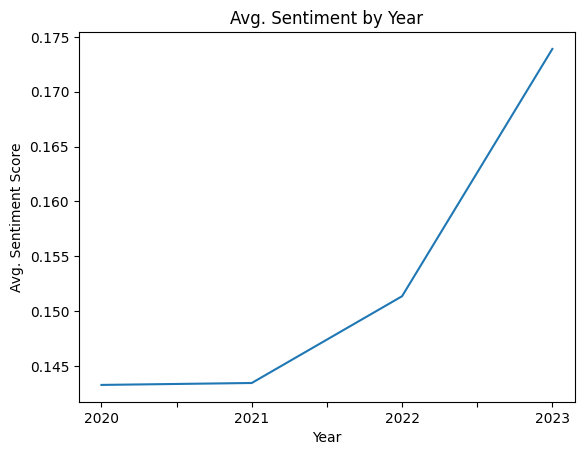

In [8]:
# Average Sentiment over the years

# group by average sentiment by year
avgByYear = fullData.groupby(['year'])['compound'].mean()

# plot the findings
avgByYear.plot(kind = 'line', title='Avg. Sentiment by Year', ylabel = 'Avg. Sentiment Score', xlabel='Year');

#### Sentiment in YouTube comments has increased every year since 2020.

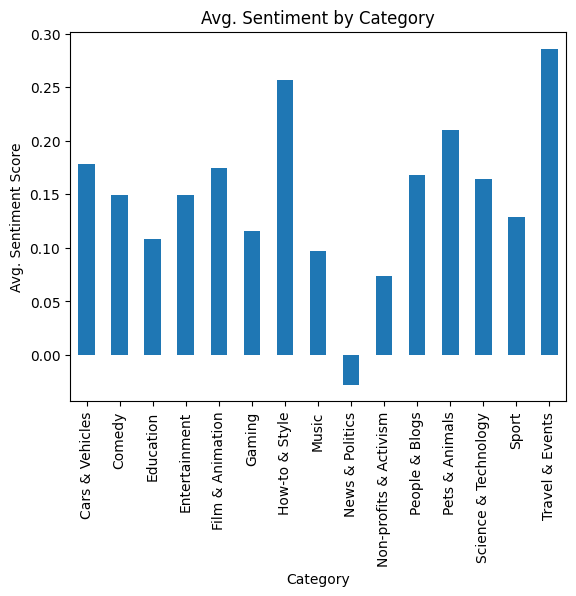

In [9]:
# sentiment by category of video 
sentimentByCategory = fullData.groupby(['categoryName'])['compound'].mean()

# plot
sentimentByCategory.plot(kind = 'bar', title='Avg. Sentiment by Category', ylabel = 'Avg. Sentiment Score', xlabel='Category');

#### News & Politics is the only category with negative average sentiment

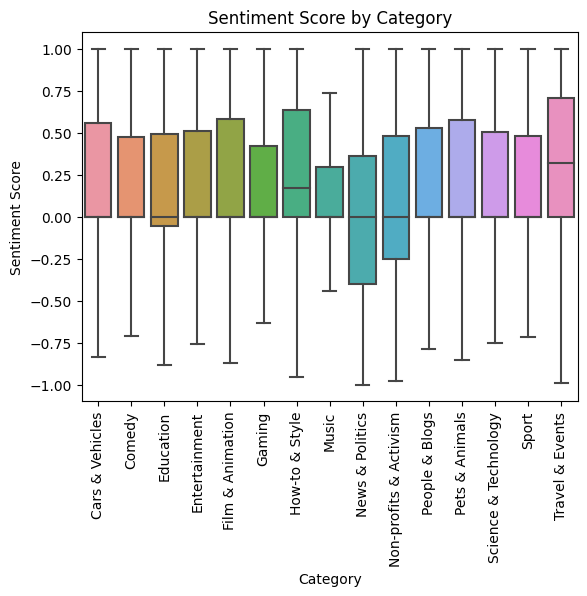

In [10]:
myOrder = sorted(fullData['categoryName'].unique())
# now try the same thing with a boxplot
sns.boxplot(x='categoryName', y='compound', data=fullData, showfliers=False, order = myOrder).set(
title = 'Sentiment Score by Category');
plt.xlabel('Category')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=90);

#### News & Politics has the talleset box, indicating the widest spread in sentiment among the categories

### Check for correlation

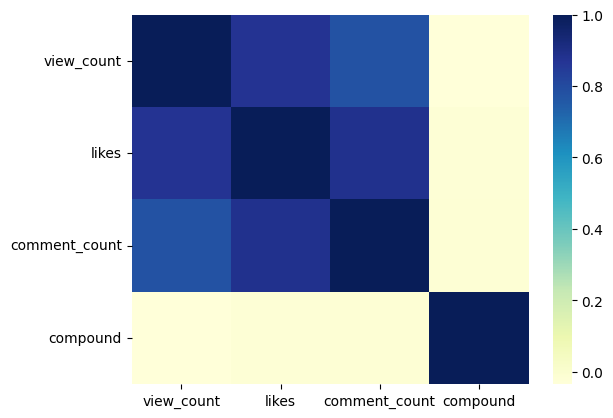

In [15]:
correlation = fullData[['view_count', 'likes', 'comment_count', 'compound']].corr()
sns.heatmap(correlation, cmap ='YlGnBu');

#### Sentiment Score seemingly has very little correlation with any of the other metrics tracked